<a href="https://colab.research.google.com/github/anna-alt/AI-Lab/blob/main/SceneRecognition1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from torchvision import models

import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:


trainset_size = 1000
val_size = 100
num_epochs = 10
image_size = (224,224)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(image_size),
                              
                              ])
# Download and load the training data
trainset = datasets.SUN397('/content/drive/MyDrive/Data', download= False, transform=transform)
splittrain = torch.utils.data.random_split(trainset, [trainset_size, len(trainset) - trainset_size])[0]
train_loader = DataLoader(splittrain, batch_size=32,num_workers = 2, shuffle=True)

validationset = datasets.SUN397("/content/drive/MyDrive/Data", download=False, transform=transform)
splitvalidation = torch.utils.data.random_split(validationset, [val_size, len(trainset) - val_size])[0]
val_loader = DataLoader(splitvalidation, batch_size=32,num_workers = 2, shuffle=True)



In [6]:
model = models.resnet50(weights = "DEFAULT")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()


In [8]:
def train(epoch, log_interval=20):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [9]:

def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(val_loader)
    loss_vector.append(val_loss)

    

    accuracy = 100. * correct.to(torch.float32) / len(val_loader.dataset)
    accuracy_vector.append(accuracy)

    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), accuracy))

In [10]:
#Definisco una funzione per stampare la label predetta e quella corretta

def Predic(loss_vector,accuracy_vector):
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    print( pred)
    print("/n")
    print(target)


In [11]:
lossv, accv = [], []
for epoch in range(1, num_epochs + 1):
    train(epoch)
    validate(lossv, accv)
    Predic(lossv,accv)

Train Epoch: 1 [0/1000 (0%)]	Loss: 7.851521
Train Epoch: 1 [640/1000 (62%)]	Loss: 6.745834

Validation set: Average loss: 6.7582, Accuracy: 0/100 (0%)

tensor([179, 786, 478, 430], device='cuda:0')
/n
tensor([249,  66, 219,  60], device='cuda:0')
Train Epoch: 2 [0/1000 (0%)]	Loss: 5.890110
Train Epoch: 2 [640/1000 (62%)]	Loss: 5.013466

Validation set: Average loss: 6.4057, Accuracy: 3/100 (3%)

tensor([973, 981, 174, 213], device='cuda:0')
/n
tensor([366, 236, 358, 348], device='cuda:0')
Train Epoch: 3 [0/1000 (0%)]	Loss: 3.968856
Train Epoch: 3 [640/1000 (62%)]	Loss: 3.446526

Validation set: Average loss: 6.0838, Accuracy: 6/100 (6%)

tensor([221, 213, 183, 334], device='cuda:0')
/n
tensor([136, 213, 284,  66], device='cuda:0')
Train Epoch: 4 [0/1000 (0%)]	Loss: 1.706883
Train Epoch: 4 [640/1000 (62%)]	Loss: 1.826886

Validation set: Average loss: 6.2978, Accuracy: 10/100 (10%)

tensor([697, 130,  84, 334], device='cuda:0')
/n
tensor([137, 235,  44, 175], device='cuda:0')
Train Epoc

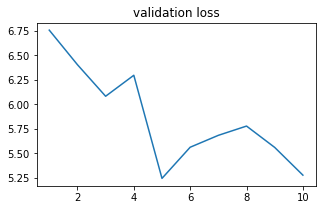

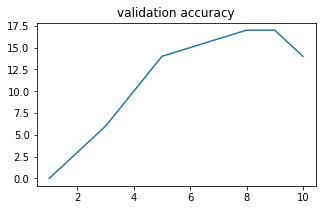

In [13]:

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), accv)
plt.title('validation accuracy');
     